In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import networkx as nx
import matplotlib.pyplot as plt
import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import fine_time_coupling_samples
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import h5py
import pynwb
import hdmf
print('pd', pd.__version__)
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


# Content

[Explores all pairs](#Explore_pairs)

[Graph analysis](#graph_analysis)

In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [4]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

# Extract data from multiple brain areas

### Neurons Selection

In [5]:
probes = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeA    78
probeD    78
probeB    57
probeF    47
Name: probe_description, dtype: int64

443

In [6]:
map_probe_to_area = session.map_probe_to_ecephys_structure_acronym(
        visual_only=False)
display(map_probe_to_area)
map_probe_to_area = session.map_probe_to_ecephys_structure_acronym(
        visual_only=True)
display(map_probe_to_area)

{'probeA': array(['APN', 'NOT', 'MB', 'DG', 'CA1', 'VISam'], dtype=object),
 'probeB': array(['LP', 'DG', 'CA1', 'VISam'], dtype=object),
 'probeC': array(['DG', 'ProS', 'SUB', 'VISp'], dtype=object),
 'probeD': array(['CA3', 'CA1', 'VISl'], dtype=object),
 'probeE': array(['LGv', 'CA3', 'CA2', 'CA1', 'VISal'], dtype=object),
 'probeF': array(['APN', 'TH', 'Eth', 'LP', 'CA3', 'DG', 'CA1', 'VISrl'], dtype=object)}

{'probeA': ['VISam'],
 'probeB': ['VISam'],
 'probeC': ['VISp'],
 'probeD': ['VISl'],
 'probeE': ['VISal'],
 'probeF': ['VISrl']}

# Fine Time Coupling Model

In [7]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)

## Trials Selection

#### drifting gratings

In [8]:
orientation = [180, 225., 270.]  # 'null'
temporal_frequency = [4., 8.]  # 'null'
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[
    stimulus_table['orientation'].isin(orientation) & 
    stimulus_table['temporal_frequency'].isin(temporal_frequency)]

all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
model.print_conditions(trials_groups)

0  258 [4.0] [225.0] [ 3814  3895  3922  3967  3986  3997 31043 31151 31152 31175 31196 49251 49282 49340 49414]
1  259 [4.0] [270.0] [ 3815  3832  3851  3893  3910  3969 31009 31140 31189 49221 49243 49252 49303 49314 49385]
2  269 [4.0] [180.0] [ 3834  3945 31045 31082 31134 31139 31141 49218 49235 49236 49237 49246 49259 49306 49326]
3  278 [8.0] [225.0] [ 3866  3878  3925  3937  3984 31142 31159 31174 31194 49290 49307 49374 49390 49401 49418]
4  280 [8.0] [270.0] [ 3872  3900  3905  3946  3956  3980 31021 31046 31064 31080 31173 31182 31188 49211 49225]
5  286 [8.0] [180.0] [ 3933  3949  3962 31154 31165 31177 31187 31199 49226 49228 49240 49280 49328 49332 49405]
total num trials: 90


In [118]:
# condition_ids = [251, 255, 261, 270, 278]  # x5  7913
# condition_ids = [251, 255, 261, 270, 278, 284] # x6  7913
# condition_ids = [278, 270, 255, 253, 262, 251, 258, 246, 263, 275, 247, 273]  # x12  7913

# condition_ids = [275, 268, 270, 284, 274, 249, 263, 261,
#                  278, 267, 280, 256, 260, 257, 281]  # x15 7989
# condition_ids = [275, 246, 268, 270, 284, 274, 249, 263, 265, 261,
#                  286, 258, 278, 267, 280, 256, 260, 257, 281]  # x19  7989
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989

In [8]:
condition_ids = [280, 256, 260, 257, 281]

stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
model.print_conditions(trials_groups)

0  256 temp freq [15.0] orient [270.0] contrast [0.8] [ 3811  3845  3942  3958 31003 31056 31112 31126 31137 31169 31191 49260 49305 49344 49381]
1  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
2  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
3  280 temp freq [8.0] orient [270.0] contrast [0.8] [ 3872  3900  3905  3946  3956  3980 31021 31046 31064 31080 31173 31182 31188 49211 49225]
4  281 temp freq [15.0] orient [315.0] contrast [0.8] [ 3889  3921  3944  3981  3989 31014 31035 31066 31071 31166 31172 49323 49380 49394 49431]
total num trials: 75


## Spike Trains

In [9]:
trial_time_window=[0.0, 2.0]
dt=0.005
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
spike_trains = model.get_trial_metric_per_unit_per_trial(
    stimulus_presentation_ids=all_trials_indices,
    unit_ids=selected_units.index.values,
    trial_time_window=trial_time_window,
    metric_type='spike_trains', dt=dt)
spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_times')
# spike_counts = model.get_trial_metric_per_unit_per_trial(
#         stimulus_presentation_ids=all_trials_indices,
#         unit_ids=selected_units.index.values,
#         trial_time_window=trial_time_window,
#         metric_type='count', empty_fill=0)

In [10]:
display(spike_trains.shape)
display(spike_trains.iloc[0,0].shape)
display(spike_times.shape)
# display(spike_times.head())

(443, 75)

(400,)

(443, 75)

# Exploration

##### Individual pair.

In [ ]:
jittertool = jitter.JitterTool()

# spike_times_x = spike_times.iloc[15].tolist()
# spike_times_y = spike_times.iloc[17].tolist()
spike_times_x = spike_times.loc[951104192].tolist()
spike_times_y = spike_times.loc[951109435].tolist()

length = 2
spk_bin_width = 0.0002
lag_range = [-0.08, 0.08]
jitter_window_width = 0.05
num_jitter = 300
_ = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, length,
      lag_range, jitter_window_width=jitter_window_width, num_jitter=num_jitter, ci_alpha=0.01, verbose=True)


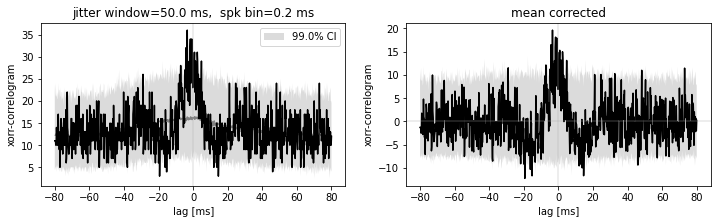

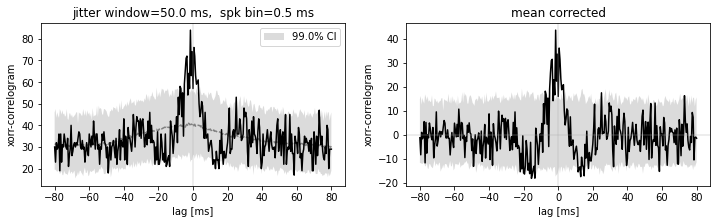

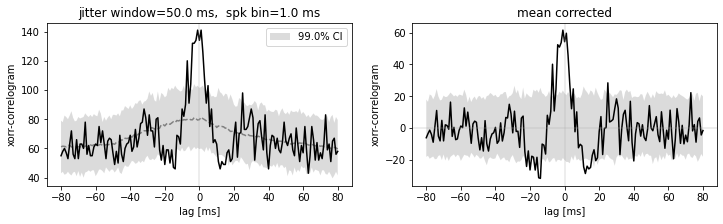

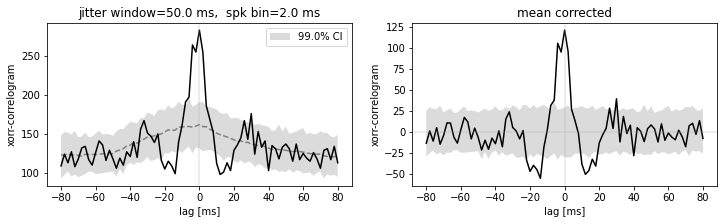

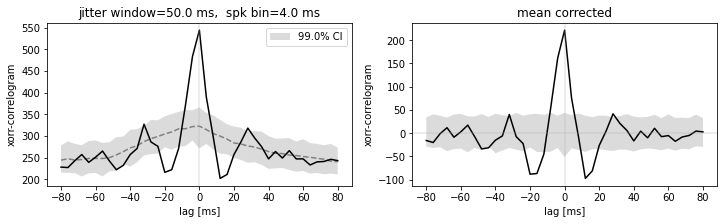

##### Run for all pairs.

In [651]:
jittertool = jitter.JitterTool()

spike_times_0 = spike_times.iloc[15].tolist()
spike_times_1 = spike_times.iloc[17].tolist()

trial_length = 2
spk_bin_width = 0.004
lag_range = [-0.08, 0.08]
jitter_window_width = 0.04
num_jitter = 1000

spike_times_x = spike_times.iloc[15].tolist()
spike_times_y = spike_times.iloc[17].tolist()

spike_hist_x, bins = jittertool.bin_spike_times(spike_times_x, spk_bin_width, trial_length)
spike_hist_y, _    = jittertool.bin_spike_times(spike_times_y, spk_bin_width, trial_length)
xorr_raw, lags = jittertool.cross_correlation(bins, spike_hist_x, spike_hist_y, lag_range, verbose=False)

# Jitter surrogate.
num_trials = len(spike_times_x)
num_lags = len(lags)
xorr_jitter = np.zeros([num_jitter, num_lags])

for r in trange(num_jitter):
    spike_times_surrogate_x = jittertool.jitter_spike_times_interval(spike_times_x, jitter_window_width, num_jitter=1, verbose=False)
    spike_hist_surrogate_x, _ = jittertool.bin_spike_times(spike_times_surrogate_x, spk_bin_width, trial_length)    
    xorr_jitter[r], lags = jittertool.cross_correlation(bins, spike_hist_surrogate_x, spike_hist_y, lag_range, verbose=False)



# Explores all pairs. <a name='Explore_pairs'></a>

In [15]:
model = fine_time_coupling_model.FineTimeCouplingModel(session)
model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                   trial_time_window, probes=['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'], num_areas=6, verbose=False)

Condition: 0  stimulus_condition_id:256
Condition: 1  stimulus_condition_id:257
Condition: 2  stimulus_condition_id:260
Condition: 3  stimulus_condition_id:280
Condition: 4  stimulus_condition_id:281


##### Select active neurons.

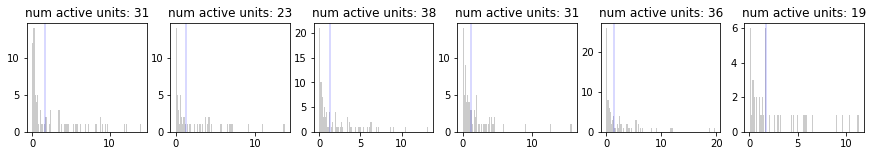

In [16]:
active_firing_rate_quantile_threshold = 0.6
# active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='all', verbose=True)
active_units = model.get_active_units(active_firing_rate_quantile_threshold, group_type='probe', verbose=True)

### construct unit pairs.

##### between probes

In [53]:
pair_type = 'between_probe'  # 'all', 'between_probe', 'within_probe'
between_probe_pairs = model.construct_unit_pairs(active_units, pair_type=pair_type, verbose=True)

num_pairs: 13066


In [55]:
spk_bin_width=0.002
lag_range=[-0.08, 0.08]
jitter_window_width=0.06
distribution_type='poisson'
num_jitter=500
ci_alpha=0.01

xorr_between_probe_pairs = model.explore_all_pairs_cross_correlation_jitter(
    between_probe_pairs, spk_bin_width, lag_range=lag_range, jitter_window_width=jitter_window_width, 
    distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=ci_alpha, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13066/13066 [1:06:14<00:00,  3.29it/s]


In [58]:
model.detect_between_probe_unit_pairs(active_units, between_probe_pairs, xorr_between_probe_pairs, detect_threshold=0.02, verbose=False)

Total units: 178
Total pairs: 13066
probeA -- probeB
num significant pairs: 11
significant pairs portion: 1.5%
probeA -- probeC
num significant pairs: 42
significant pairs portion: 3.6%
probeA -- probeD
num significant pairs: 15
significant pairs portion: 1.6%
probeA -- probeE
num significant pairs: 28
significant pairs portion: 2.5%
probeA -- probeF
num significant pairs: 6
significant pairs portion: 1.0%
probeB -- probeC
num significant pairs: 15
significant pairs portion: 1.7%
probeB -- probeD
num significant pairs: 4
significant pairs portion: 0.6%
probeB -- probeE
num significant pairs: 8
significant pairs portion: 1.0%
probeB -- probeF
num significant pairs: 1
significant pairs portion: 0.2%
probeC -- probeD
num significant pairs: 55
significant pairs portion: 4.7%
probeC -- probeE
num significant pairs: 82
significant pairs portion: 6.0%
probeC -- probeF
num significant pairs: 24
significant pairs portion: 3.3%
probeD -- probeE
num significant pairs: 43
significant pairs portion

In [61]:
file_path = f'D:/Brain_Network/Output/models/jitter/{session_id}_xorr_between_probe_pairs_active_06.pkl'
# util.save_variable(file_path, xorr_between_probe_pairs)

util.save_variable, save variable to:  D:/Brain_Network/Output/models/jitter/798911424_xorr_between_probe_pairs_active_06.pkl


##### Within probes

In [45]:
pair_type = 'within_probe'  # 'all', 'between_probe', 'within_probe'
within_probe_pairs = model.construct_unit_pairs(active_units, pair_type=pair_type, verbose=True)

num_pairs: 2687


In [46]:
spk_bin_width=0.002
lag_range=[-0.08, 0.08]
jitter_window_width=0.06
distribution_type='poisson'
num_jitter=500
ci_alpha=0.01

xorr_within_probe_pairs = model.explore_all_pairs_cross_correlation_jitter(
    within_probe_pairs, spk_bin_width, lag_range=lag_range, jitter_window_width=jitter_window_width, 
    distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=ci_alpha, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2687/2687 [15:08<00:00,  2.96it/s]


In [47]:
model.detect_within_probe_unit_pairs(active_units, within_probe_pairs, xorr_within_probe_pairs, detect_threshold=0.02, verbose=False)

Total units: 178
Total pairs: 2687
probeA
num significant pairs: 31
significant pairs portion: 6.7%
probeB
num significant pairs: 5
significant pairs portion: 2.0%
probeC
num significant pairs: 149
significant pairs portion: 21.2%
probeD
num significant pairs: 20
significant pairs portion: 4.3%
probeE
num significant pairs: 41
significant pairs portion: 6.5%
probeF
num significant pairs: 5
significant pairs portion: 2.9%
Total cnt: 251
Overall significant ratio: 9.34%


Save xorr_pairs

In [48]:
file_path = f'D:/Brain_Network/Output/models/jitter/{session_id}_xorr_within_probe_pairs_active_06.pkl'
# util.save_variable(file_path, xorr_within_probe_pairs)

util.save_variable, save variable to:  D:/Brain_Network/Output/models/jitter/798911424_xorr_within_probe_pairs_active_06.pkl


Load xorr_pairs

In [18]:
file_path = 'D:/Brain_Network/Output/jitter/798911424_xorr_between_probe_pairs_active_06.pkl'
xorr_between_probe_pairs = util.load_variable(file_path)
file_path = 'D:/Brain_Network/Output/jitter/798911424_xorr_within_probe_pairs_active_06.pkl'
xorr_within_probe_pairs = util.load_variable(file_path)

# Plot connection graph.

#### Between area.

{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}


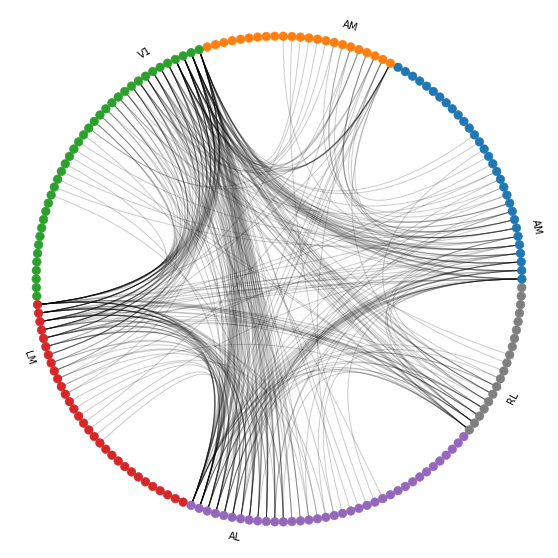

In [19]:
figure_path = project_dir + 'Output/fig/xorr_between_probe_pairs.pdf'
layout_units = active_units
between_probe_graph = model.build_graph_from_xorr_pairs(layout_units, xorr_between_probe_pairs,
        detect_threshold=0.02, graph_template=None, figure_path=None, verbose=2)

In [ ]:
between_probe_graph.edges()

#### With area probes.

{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
Save figure to: D:/Brain_Network/Output/fig/xorr_within_probe_pairs.pdf


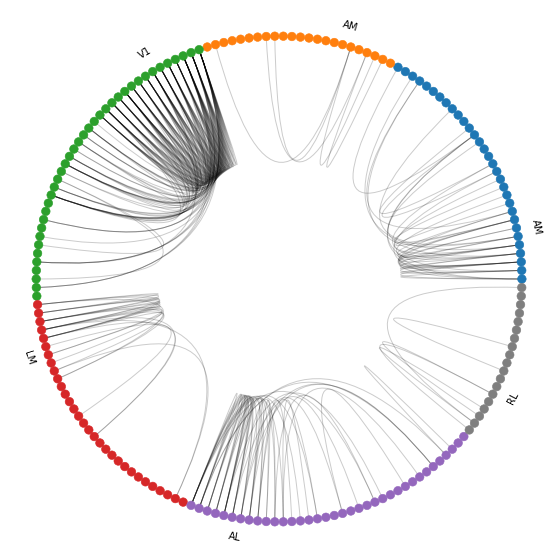

In [429]:
figure_path = project_dir + 'Output/fig/xorr_within_probe_pairs.pdf'
# layout_units = None
layout_units = active_units
within_probe_graph = model.build_graph_from_xorr_pairs(layout_units, xorr_within_probe_pairs,
        detect_threshold=0.02, graph_template=between_probe_graph, figure_path=None, verbose=2)

{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}


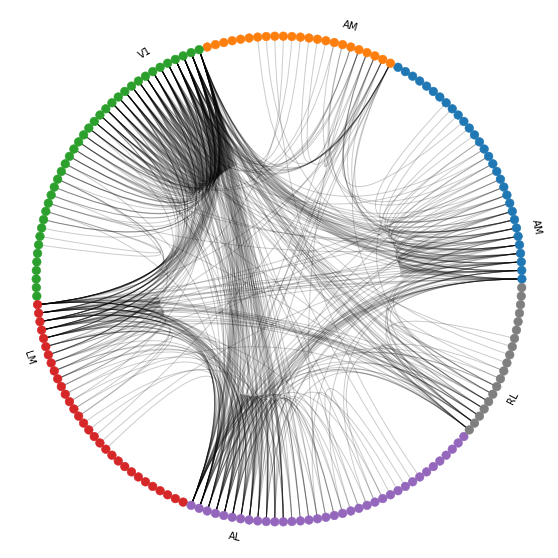

In [21]:
layout_units = active_units
xorr_all_pairs = {**xorr_within_probe_pairs, **xorr_between_probe_pairs}
whole_graph = model.build_graph_from_xorr_pairs(layout_units, xorr_all_pairs,
        detect_threshold=0.02, graph_template=None, verbose=2)

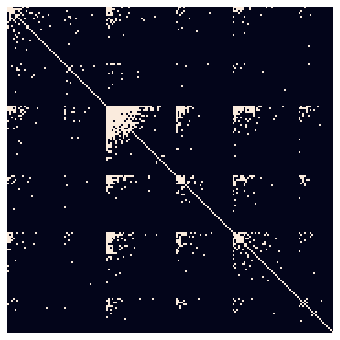

In [31]:
layout_units = active_units
xorr_all_pairs = {**xorr_within_probe_pairs, **xorr_between_probe_pairs}
whole_graph = model.build_graph_from_xorr_pairs(layout_units, xorr_all_pairs,
        detect_threshold=0.02, graph_template=None, verbose=3)

### Save networkx graph.

In [32]:
file_path = project_dir + f'Output/network/{session_id}_condition5_area6_active.pkl'
# nx.write_gpickle(whole_graph, file_path)

# Graph analysis. <a name='graph_analysis'></a>

In [111]:
layout_units = None
xorr_all_pairs = {**xorr_within_probe_pairs, **xorr_between_probe_pairs}

whole_graph = model.build_graph_from_xorr_pairs(layout_units, xorr_all_pairs,
        detect_threshold=0.02, graph_template=None, verbose=False)

#nodes 443  #edges 610
#non-zero degree nodes 135  ratio 0.3047404063205418
#hub nodes: 52
probeC    18
probeE    12
probeA     9
probeD     7
probeF     5
probeB     1
Name: probe_description, dtype: int64


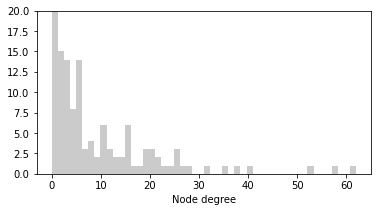

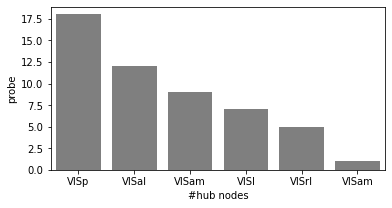

In [164]:
model.graph_statistics(whole_graph)

In [281]:
# between_probe_graph xorr_between_probe_pairs,
hub_nodes, hub_nodes_info = model.find_hub_units(between_probe_graph, degree_threshold=10)
print(hub_nodes_info)
# display(selected_units.loc[hub_nodes])

[(951093608, 12), (951093821, 12), (951093688, 18), (951097947, 12), (951103361, 11), (951103262, 10), (951103332, 36), (951103632, 25), (951103958, 29), (951104031, 12), (951104064, 10), (951104192, 36), (951109137, 19), (951109118, 21), (951109282, 12), (951109319, 14), (951109435, 31), (951112712, 24), (951113039, 11), (951113271, 28), (951113464, 10), (951113514, 14), (951113717, 15), (951116768, 12), (951117090, 10)]


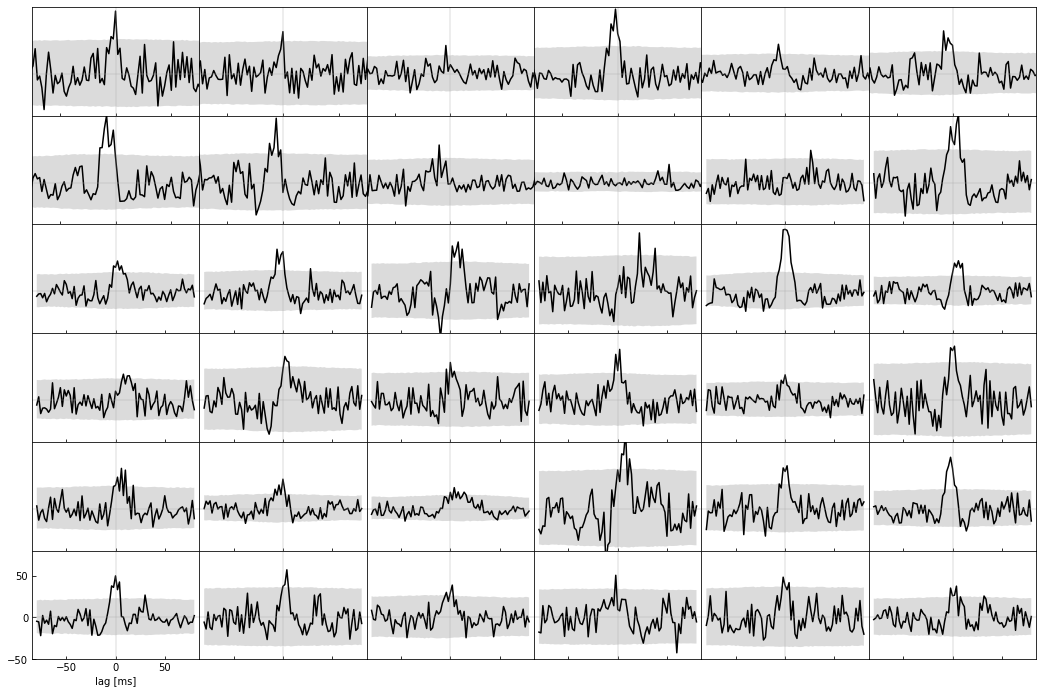

In [300]:
model.plot_unit_xorr(951104192, xorr_between_probe_pairs, detect_threshold=0.02, num_rows_cols=[6, 6])

#### Between areas.

[(16, 86), (6, 71), (7, 47), (0, 46), (1, 35), (2, 28), (14, 13), (8, 11), (15, 10), (9, 4), (3, 1), (4, 1), (5, 1), (10, 1), (11, 1), (12, 1), (13, 1), (17, 1)]
Save figure to: D:/Brain_Network/Output/fig/xorr_between_probe_pairs_clusters.png


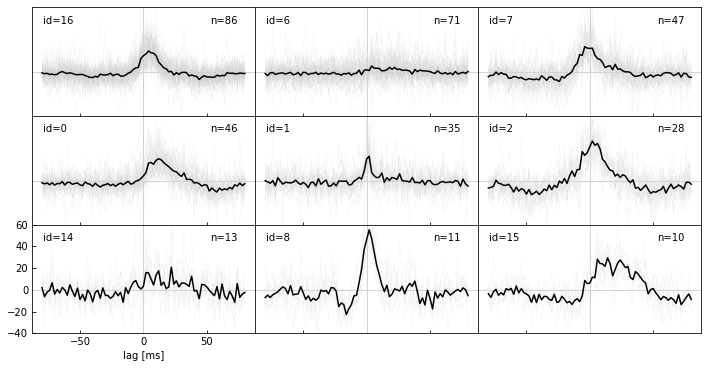

In [434]:
figure_path = project_dir + 'Output/fig/xorr_between_probe_pairs_clusters.png'
model.xorr_raw_clustering(xorr_between_probe_pairs, detect_threshold=0.02, num_clusters=18, num_rows_cols=(3,3), figure_path=None)

#### Between area for each pair.

{'probeA': ['VISam'], 'probeB': ['VISam'], 'probeC': ['VISp'], 'probeD': ['VISl'], 'probeE': ['VISal'], 'probeF': ['VISrl']}
('probeA', 'probeB') probeA_AM___probeB_AM
(cluster_id, cnt) [(4, 3), (1, 2), (0, 1), (2, 1), (3, 1), (5, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeA_AM___probeB_AM_xorr_clusters.pdf


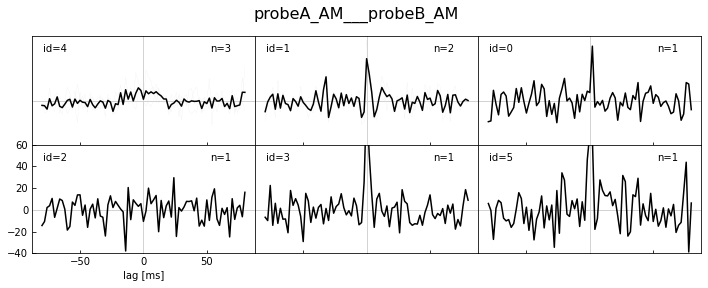

('probeA', 'probeC') probeA_AM___probeC_V1
(cluster_id, cnt) [(1, 20), (2, 12), (5, 4), (3, 2), (0, 1), (4, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeA_AM___probeC_V1_xorr_clusters.pdf


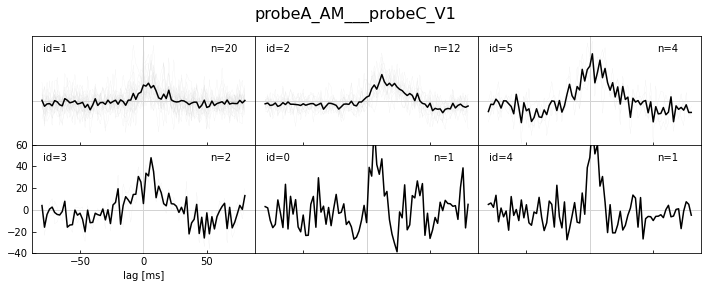

('probeA', 'probeD') probeA_AM___probeD_LM
(cluster_id, cnt) [(5, 6), (1, 2), (2, 2), (0, 1), (3, 1), (4, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeA_AM___probeD_LM_xorr_clusters.pdf


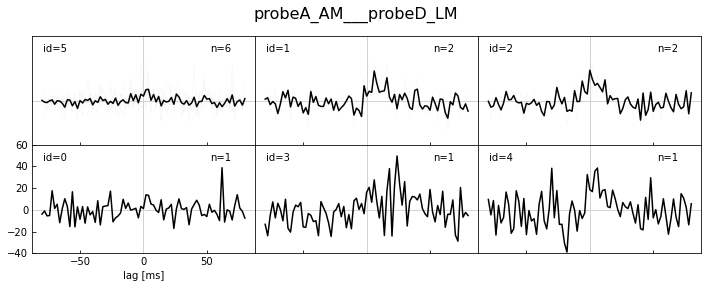

('probeA', 'probeE') probeA_AM___probeE_AL
(cluster_id, cnt) [(5, 18), (1, 4), (0, 1), (2, 1), (3, 1), (4, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeA_AM___probeE_AL_xorr_clusters.pdf


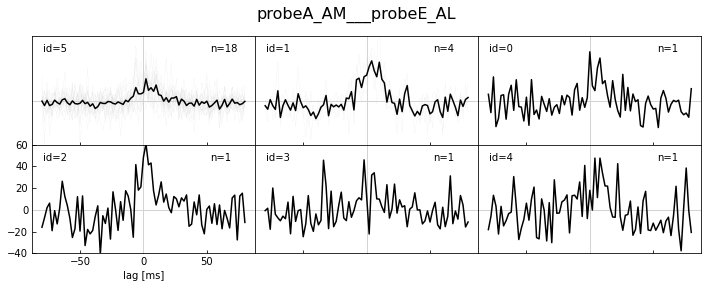

('probeA', 'probeF') probeA_AM___probeF_RL
(cluster_id, cnt) [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeA_AM___probeF_RL_xorr_clusters.pdf


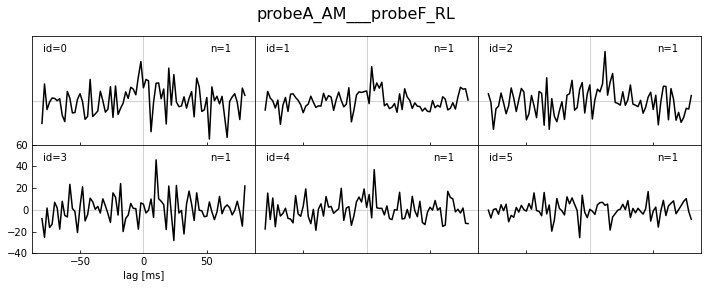

('probeB', 'probeC') probeB_AM___probeC_V1
(cluster_id, cnt) [(5, 5), (2, 4), (0, 1), (1, 1), (3, 1), (4, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeB_AM___probeC_V1_xorr_clusters.pdf


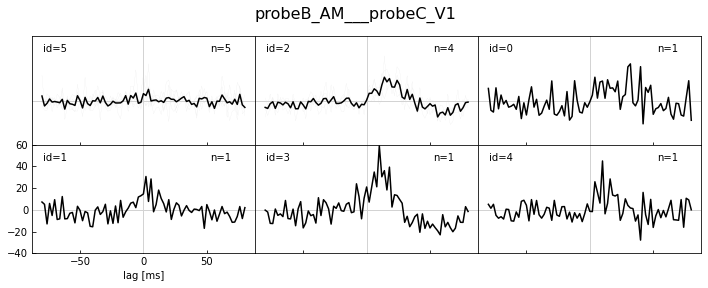

('probeB', 'probeD') probeB_AM___probeD_LM
(cluster_id, cnt) [(0, 1), (1, 1), (2, 1), (3, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeB_AM___probeD_LM_xorr_clusters.pdf


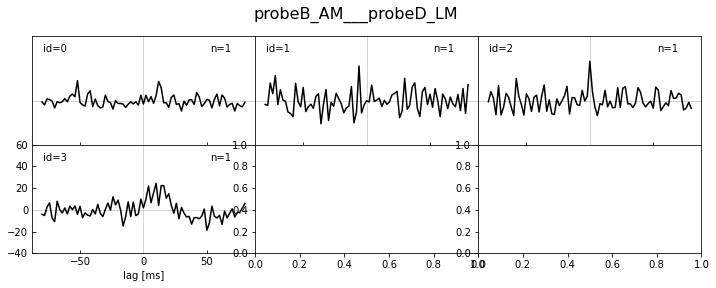

('probeB', 'probeE') probeB_AM___probeE_AL
(cluster_id, cnt) [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeB_AM___probeE_AL_xorr_clusters.pdf


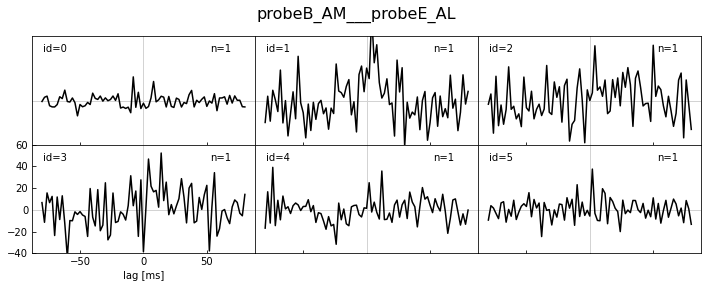

('probeB', 'probeF') probeB_AM___probeF_RL
('probeC', 'probeD') probeC_V1___probeD_LM
(cluster_id, cnt) [(2, 26), (1, 9), (3, 7), (0, 5), (4, 3), (7, 3), (5, 1), (6, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeC_V1___probeD_LM_xorr_clusters.pdf


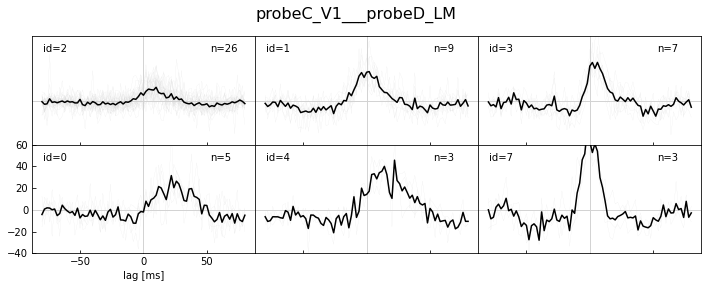

('probeC', 'probeE') probeC_V1___probeE_AL
(cluster_id, cnt) [(7, 38), (1, 23), (2, 14), (0, 3), (3, 1), (4, 1), (5, 1), (6, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeC_V1___probeE_AL_xorr_clusters.pdf


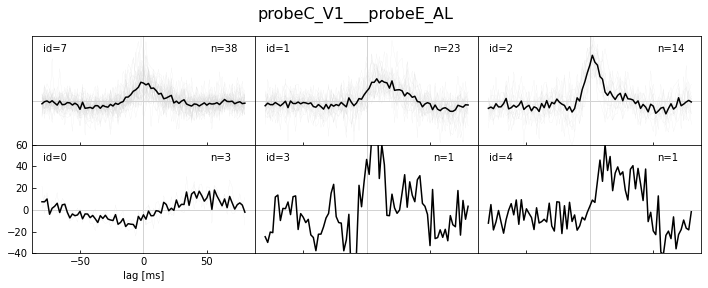

('probeC', 'probeF') probeC_V1___probeF_RL
(cluster_id, cnt) [(3, 12), (1, 4), (0, 2), (5, 2), (2, 1), (4, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeC_V1___probeF_RL_xorr_clusters.pdf


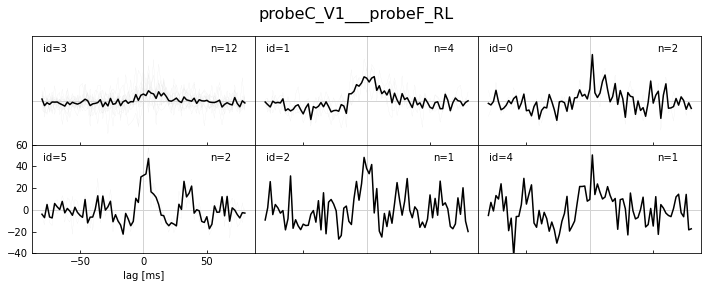

('probeD', 'probeE') probeD_LM___probeE_AL
(cluster_id, cnt) [(0, 28), (5, 9), (1, 1), (2, 1), (3, 1), (4, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeD_LM___probeE_AL_xorr_clusters.pdf


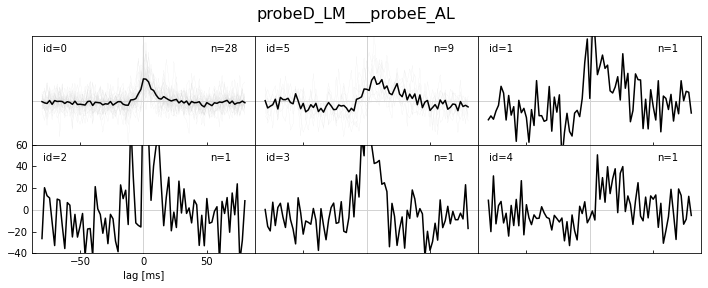

('probeD', 'probeF') probeD_LM___probeF_RL
(cluster_id, cnt) [(1, 7), (0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeD_LM___probeF_RL_xorr_clusters.pdf


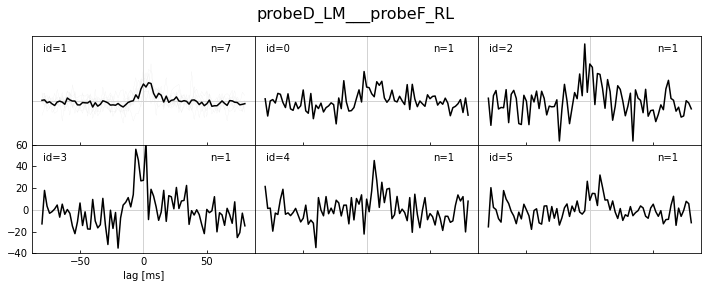

('probeE', 'probeF') probeE_AL___probeF_RL
(cluster_id, cnt) [(1, 4), (0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
Save figure to: D:/Brain_Network/Output/fig/probeE_AL___probeF_RL_xorr_clusters.pdf


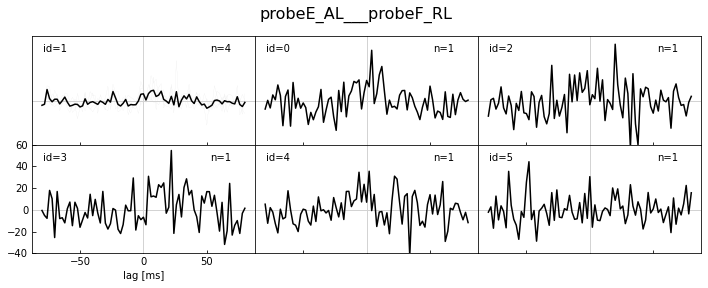

In [498]:
output_dir = project_dir + 'Output/fig/'
model.xorr_raw_clustering_grouped(xorr_between_probe_pairs, detect_threshold=0.02, output_dir=output_dir)

#### Within areas

[(1, 114), (2, 82), (7, 31), (3, 13), (0, 4), (5, 4), (6, 2), (4, 1)]


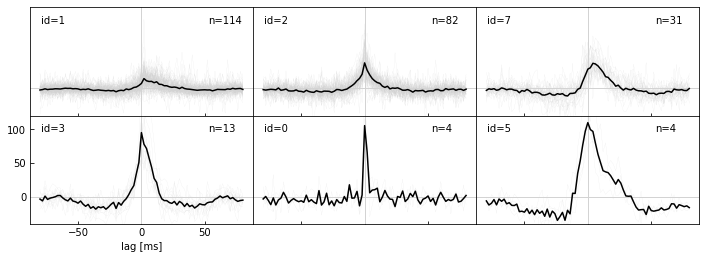

In [384]:
figure_path = project_dir + 'Output/fig/xorr_between_probe_pairs_clusters.png'
# model.xorr_raw_clustering(xorr_within_probe_pairs, detect_threshold=0.02, num_clusters=8, num_rows_cols=(3, 4))
model.xorr_raw_clustering(xorr_within_probe_pairs, detect_threshold=0.02, num_clusters=8, num_rows_cols=(2,3), figure_path=None)